Theano + Lasagne :: MLP
==============================

This is a quick illustration of a single-layer network training on the 300*300 data.

( Credit for the original workbook : Eben Olson :: https://github.com/ebenolson/pydata2015 )

In [9]:
import numpy as np
import theano
import theano.tensor as T
import lasagne

import matplotlib.pyplot as plt
%matplotlib inline

import gzip
import pickle

import pandas as pd
from sklearn.cross_validation import train_test_split

In [10]:
# Seed for reproducibility
np.random.seed(42)

### Get the MNIST data
Put it into useful subsets, and show some of it as a sanity check

In [5]:
data1 = pd.read_csv('./300_300_data/1.csv', sep=",")
data2 = pd.read_csv('./300_300_data/2.csv', sep=",")
data3 = pd.read_csv('./300_300_data/3.csv', sep=",")
data4 = pd.read_csv('./300_300_data/4.csv', sep=",")
data=data1.append(data2,ignore_index = True)
data=data.append(data3,ignore_index = True)
data=data.append(data4,ignore_index = True)

In [77]:
X_train, X_val, y_train, y_val = train_test_split(data[data.columns[0:90000]], data[data.columns[90000]], test_size=0.25, random_state=200)

In [78]:
X_train = X_train.as_matrix()
X_val = X_val.as_matrix()
y_train = y_train.as_matrix()
y_val = y_val.as_matrix()

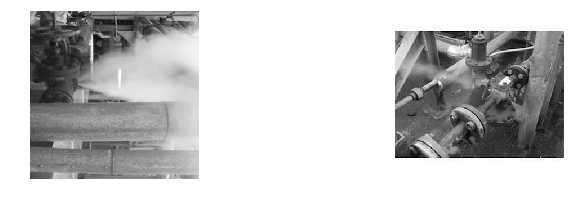

In [84]:
# Plot the first few examples 
plt.figure(figsize=(12,3))
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.imshow(X_train[i].reshape((300, 300)), cmap='gray', interpolation='nearest')
    plt.axis('off')

In [85]:
# For training, we want to sample examples at random in small batches
def batch_gen(X, y, N):
    while True:
        idx = np.random.choice(len(y), N)
        yield X[idx].astype('float32'), y[idx].astype('int32')

### Create the Network
Actually, this is not even a 'deep' network - the outputs are wired (via a full matrix of weights) to the outputs directly (the outputs then have a 'softmax' operation applied, so that only 1 class is chosen)

In [86]:
# A very simple network, a single layer with one neuron per target class.
# Using the softmax activation function gives us a probability distribution at the output.
l_in = lasagne.layers.InputLayer((None, 90000))
l_out = lasagne.layers.DenseLayer(
    l_in,
    num_units=2,
    nonlinearity=lasagne.nonlinearities.softmax)

In [87]:
# Symbolic variables for our input features and targets
X_sym = T.matrix()
y_sym = T.ivector()

In [88]:
# Theano expressions for the output distribution and predicted class
output = lasagne.layers.get_output(l_out, X_sym)
pred = output.argmax(-1)

### Set up the Loss Function
So that we can perform Gradient Descent to improve the networks' parameters during training

In [89]:
# The loss function is cross-entropy averaged over a minibatch, we also compute accuracy as an evaluation metric
loss = T.mean(lasagne.objectives.categorical_crossentropy(output, y_sym))
acc = T.mean(T.eq(pred, y_sym))

In [90]:
# We retrieve all the trainable parameters in our network - a single weight matrix and bias vector
params = lasagne.layers.get_all_params(l_out)
print(params)

[W, b]


In [91]:
# Compute the gradient of the loss function with respect to the parameters.
# The stochastic gradient descent algorithm produces updates for each param
grad = T.grad(loss, params)
updates = lasagne.updates.sgd(grad, params, learning_rate=0.05)
print(updates)

OrderedDict([(W, Elemwise{sub,no_inplace}.0), (b, Elemwise{sub,no_inplace}.0)])


Create the functions that define the training loss, validation loss, and predicted class for any given inputs (combined with targets for the loss functions)

In [92]:
# We define a training function that will compute the loss and accuracy, and take a single optimization step
f_train = theano.function([X_sym, y_sym], [loss, acc], updates=updates)

In [93]:
# The validation function is similar, but does not update the parameters
f_val = theano.function([X_sym, y_sym], [loss, acc])

In [94]:
# The prediction function doesn't require targets, and outputs only the predicted class values
f_predict = theano.function([X_sym], pred)

### Batching of Training
For efficiency, we operate on data in batches, so that (for instance) a GPU can operate on multiple examples simultaneously

In [95]:
# We'll choose a batch size, and calculate the number of batches in an "epoch"
# (approximately one pass through the data).
BATCH_SIZE = 8
N_BATCHES = len(X_train) // BATCH_SIZE
N_VAL_BATCHES = len(X_val) // BATCH_SIZE

In [96]:
# Minibatch generators for the training and validation sets
train_batches = batch_gen(X_train, y_train, BATCH_SIZE)
val_batches = batch_gen(X_val, y_val, BATCH_SIZE)

1


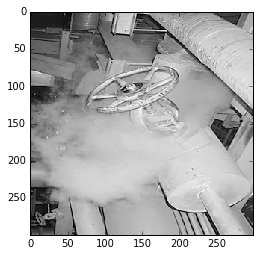

In [97]:
# Try sampling from the batch generator.
# Plot an image and corresponding label to verify they match.
X, y = next(train_batches)
plt.imshow(X[0].reshape((300, 300)), cmap='gray', interpolation='nearest')
print(y[0])

### Finally, the Training...
For each epoch, we call the training function N_BATCHES times, accumulating an estimate of the training loss and accuracy.

Then we do the same thing for the validation set.

We print out the ratio of loss in the validation set vs the training set to help recognize overfitting.

In [99]:
for epoch in range(30):
    train_loss = 0
    train_acc = 0
    for _ in range(N_BATCHES):
        X, y = next(train_batches)
        loss, acc = f_train(X, y)
        train_loss += loss
        train_acc += acc
    train_loss /= N_BATCHES
    train_acc /= N_BATCHES

    val_loss = 0
    val_acc = 0
    for _ in range(N_VAL_BATCHES):
        X, y = next(val_batches)
        loss, acc = f_val(X, y)
        val_loss += loss
        val_acc += acc
    val_loss /= N_VAL_BATCHES
    val_acc /= N_VAL_BATCHES
    
    print('Epoch {:2d}, Train loss {:.03f}     (validation : {:.03f}) ratio {:.03f}'.format(
            epoch, train_loss, val_loss, val_loss/train_loss))
    print('          Train accuracy {:.03f} (validation : {:.03f})'.format(train_acc, val_acc))
print("DONE")

Epoch  0, Train loss 8561182.863     (validation : 9350559.200) ratio 1.092
          Train accuracy 0.600 (validation : 0.500)
Epoch  1, Train loss 6090112.392     (validation : 8227109.375) ratio 1.351
          Train accuracy 0.650 (validation : 0.475)
Epoch  2, Train loss 10713193.942     (validation : 13025870.400) ratio 1.216
          Train accuracy 0.575 (validation : 0.425)
Epoch  3, Train loss 7768374.483     (validation : 11284768.650) ratio 1.453
          Train accuracy 0.683 (validation : 0.625)
Epoch  4, Train loss 7432391.736     (validation : 7410973.950) ratio 0.997
          Train accuracy 0.658 (validation : 0.475)
Epoch  5, Train loss 10070334.492     (validation : 23510262.800) ratio 2.335
          Train accuracy 0.600 (validation : 0.400)
Epoch  6, Train loss 7719549.450     (validation : 7467267.150) ratio 0.967
          Train accuracy 0.667 (validation : 0.550)
Epoch  7, Train loss 3144366.067     (validation : 11891825.300) ratio 3.782
          Train accura

### Visualising the Weight Matrix
We can retrieve the value of the trained weight matrix from the output layer.

It can be interpreted as a collection of images, one per class.

In [100]:
weights = l_out.W.get_value()
print(weights.shape)

(90000, 2)


### Plot the weight images.  
We should expect to recognize similarities to the target images:

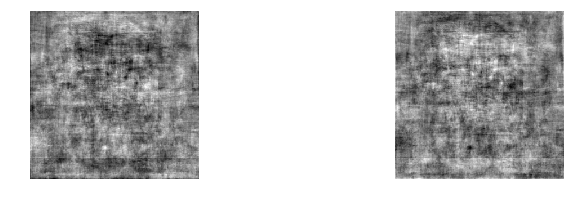

In [102]:
plt.figure(figsize=(12,3))
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.imshow(weights[:,i].reshape((300, 300)), cmap='gray', interpolation='nearest')
    plt.axis('off')

Exercises
=====

1. Logistic regression
----------------------

The simple network we created is similar to a logistic regression model. Verify that the accuracy is close to that of `sklearn.linear_model.LogisticRegression`.

In [ ]:
# Uncomment and execute this cell for an example solution
# %load spoilers/logreg.py

2. Hidden layer
---------------

Try adding one or more "hidden" `DenseLayers` between the input and output. Experiment with different numbers of hidden units.

In [ ]:
# Uncomment and execute this cell for an example solution
# %load spoilers/hiddenlayer.py

3. Optimizer
------------

Try one of the other algorithms available in `lasagne.updates`. You may also want to adjust the learning rate.
Visualize and compare the trained weights. Different optimization trajectories may lead to very different results, even if the performance is similar. This can be important when training more complicated networks.

In [ ]:
# Uncomment and execute this cell for an example solution
# %load spoilers/optimizer.py